In [1]:
# Needed libraries 
# Reference Material https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [2]:
#preparing the data we will use for forecasting 
df = pd.read_pickle('df_timeseries.pickle')
df_garch = df.copy()
df_garch

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,prb_id,timestamp,msm_name,from,type,group_id,step,stored_timestamp,nprb_id,new_time
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,1003454,2023-01-16 10:13:25,Ping,51.15.99.8,ping,48819905,300,1673864050,nl1,2023-01-16 11:14:10
1,5040,2.4.1,20,52.46.72.50,4,52.46.72.50,10.109.0.30,ICMP,233.0,64,...,1003747,2023-01-16 10:13:23,Ping,45.137.88.145,ping,48819905,300,1673864114,nl3,2023-01-16 11:15:14
2,5080,2.6.2,96,52.46.72.50,4,52.46.72.50,192.168.250.65,ICMP,233.0,64,...,20757,2023-01-16 10:13:11,Ping,82.116.160.225,ping,48819905,300,1673864089,es3,2023-01-16 11:14:49
3,5080,2.6.2,12,52.46.72.50,4,52.46.72.50,192.168.1.38,ICMP,234.0,64,...,53229,2023-01-16 10:13:39,Ping,83.54.157.101,ping,48819905,300,1673864090,es2,2023-01-16 11:14:50
4,5080,2.6.2,33,52.46.72.50,4,52.46.72.50,192.168.0.101,ICMP,232.0,64,...,51381,2023-01-16 10:14:34,Ping,102.34.0.4,ping,48819905,300,1673864205,ug1,2023-01-16 11:16:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28170,5040,2.4.1,3,52.46.200.93,4,52.46.200.93,192.168.1.3,ICMP,235.0,64,...,1004102,2023-01-18 09:09:59,Ping,149.90.236.149,ping,48819913,300,1674033077,pt2,2023-01-18 10:11:17
28171,5040,2.4.1,2,52.46.200.93,4,52.46.200.93,192.168.168.209,ICMP,221.0,64,...,1004200,2023-01-18 09:09:51,Ping,88.24.68.105,ping,48819913,300,1674033051,es4,2023-01-18 10:10:51
28172,5080,2.6.2,67,52.46.200.93,4,52.46.200.93,192.168.1.38,ICMP,220.0,64,...,53229,2023-01-18 09:09:21,Ping,83.54.157.101,ping,48819913,300,1674033081,es2,2023-01-18 10:11:21
28173,5040,2.4.1,49,52.46.200.93,4,52.46.200.93,10.18.246.209,ICMP,231.0,64,...,1003454,2023-01-18 09:10:09,Ping,51.15.99.8,ping,48819913,300,1674033100,nl1,2023-01-18 10:11:40


In [3]:
df_garch.prb_id.unique()

array([1003454, 1003747,   20757,   53229,   51381,   54470, 1002914,
       1004102, 1004200, 1004991], dtype=int64)

In [4]:
# Creating the prophet dataframe 

df_garch.groupby(['nprb_id','dst_addr'])

#Extracting the results of one probe and destination
df_garch = df_garch[(df_garch['nprb_id'] == 'es1') & (df_garch['dst_addr'] == "52.46.200.93")]

In [5]:
# Extracting the results column in order to process the avg rtt
df_rtt = df_garch.result.apply(pd.Series).set_axis(['ping_one','ping_two','ping_three',3,4,5],axis=1) #https://stackoverflow.com/questions/70584804/how-to-extract-list-of-dictionaries-from-pandas-column
df_rtt = df_rtt.dropna(axis=1)

#https://stackoverflow.com/questions/35711059/extract-dictionary-value-from-column-in-data-frame?noredirect=1&lq=1
df_rtt['ping_one_Value'] = df_rtt['ping_one'].apply(lambda x: x.get('rtt'))
df_rtt['ping_two_Value'] = df_rtt['ping_two'].apply(lambda x: x.get('rtt'))
df_rtt['ping_three_Value'] = df_rtt['ping_three'].apply(lambda x: x.get('rtt'))

#getting the average of the ping values 
df_rtt['avg_rtt_result'] = df_rtt[['ping_one_Value','ping_two_Value','ping_three_Value']].mean(axis=1)
df_rtt

,ping_one,ping_two,ping_three,ping_one_Value,ping_two_Value,ping_three_Value,avg_rtt_result
22549,{'rtt': 51.698169},{'rtt': 51.756525},{'rtt': 51.723537},51.698169,51.756525,51.723537,51.726077
22559,{'rtt': 50.993586},{'rtt': 50.971157},{'rtt': 51.112259},50.993586,50.971157,51.112259,51.025667
22569,{'rtt': 51.715804},{'rtt': 51.724153},{'rtt': 51.679314},51.715804,51.724153,51.679314,51.706424
22579,{'rtt': 51.063621},{'rtt': 51.03592},{'rtt': 51.056587},51.063621,51.035920,51.056587,51.052043
22589,{'rtt': 51.104533},{'rtt': 51.177799},{'rtt': 51.017722},51.104533,51.177799,51.017722,51.100018
...,...,...,...,...,...,...,...
28134,{'rtt': 54.721446},{'rtt': 54.704551},{'rtt': 54.813593},54.721446,54.704551,54.813593,54.746530
28144,{'rtt': 54.766741},{'rtt': 54.754952},{'rtt': 54.855641},54.766741,54.754952,54.855641,54.792445
28154,{'rtt': 54.694568},{'rtt': 54.759688},{'rtt': 54.732717},54.694568,54.759688,54.732717,54.728991
28164,{'rtt': 48.771845},{'rtt': 48.712132},{'rtt': 48.650611},48.771845,48.712132,48.650611,48.711529


In [6]:
#adding the avg-rtt from the three pings to the original dataframe 
df_garch =  pd.concat([df_garch,df_rtt],axis = 1)
df_garch

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,stored_timestamp,nprb_id,new_time,ping_one,ping_two,ping_three,ping_one_Value,ping_two_Value,ping_three_Value,avg_rtt_result
22549,5080,2.6.2,43,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673864259,es1,2023-01-16 11:17:39,{'rtt': 51.698169},{'rtt': 51.756525},{'rtt': 51.723537},51.698169,51.756525,51.723537,51.726077
22559,5080,2.6.2,49,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673864518,es1,2023-01-16 11:21:58,{'rtt': 50.993586},{'rtt': 50.971157},{'rtt': 51.112259},50.993586,50.971157,51.112259,51.025667
22569,5080,2.6.2,39,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673864814,es1,2023-01-16 11:26:54,{'rtt': 51.715804},{'rtt': 51.724153},{'rtt': 51.679314},51.715804,51.724153,51.679314,51.706424
22579,5080,2.6.2,48,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673865112,es1,2023-01-16 11:31:52,{'rtt': 51.063621},{'rtt': 51.03592},{'rtt': 51.056587},51.063621,51.035920,51.056587,51.052043
22589,5080,2.6.2,0,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1673865422,es1,2023-01-16 11:37:02,{'rtt': 51.104533},{'rtt': 51.177799},{'rtt': 51.017722},51.104533,51.177799,51.017722,51.100018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28134,5080,2.6.2,42,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1674031922,es1,2023-01-18 09:52:02,{'rtt': 54.721446},{'rtt': 54.704551},{'rtt': 54.813593},54.721446,54.704551,54.813593,54.746530
28144,5080,2.6.2,43,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1674032203,es1,2023-01-18 09:56:43,{'rtt': 54.766741},{'rtt': 54.754952},{'rtt': 54.855641},54.766741,54.754952,54.855641,54.792445
28154,5080,2.6.2,35,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1674032511,es1,2023-01-18 10:01:51,{'rtt': 54.694568},{'rtt': 54.759688},{'rtt': 54.732717},54.694568,54.759688,54.732717,54.728991
28164,5080,2.6.2,49,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1674032810,es1,2023-01-18 10:06:50,{'rtt': 48.771845},{'rtt': 48.712132},{'rtt': 48.650611},48.771845,48.712132,48.650611,48.711529


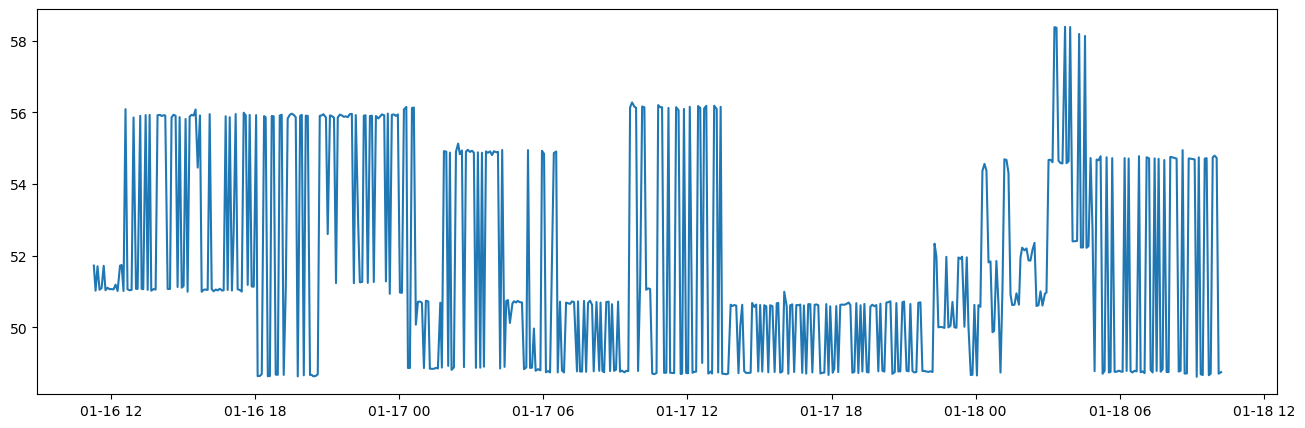

In [7]:
plt.plot(df_garch['new_time'],df_garch['avg'])
plt.show()

In [8]:
# define the model
from arch import arch_model

# Create GARCH model instance
garch_model = arch_model(df_garch['avg'],vol='GARCH',dist='Normal')


ModuleNotFoundError: No module named 'arch'

In [9]:
# Fit model to data
garch_fit = garch_model.fit()
garch_fit

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2921.3463713454153
Iteration:      2,   Func. Count:     13,   Neg. LLF: 579790.0268624285
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1371.1808715433563
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1371.5445808975714
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1342.2493841314063
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1545.7060191321002
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1345.6048362207816
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1339.5941243522516
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1339.5759026958478
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1339.5748041834017
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1339.5748041831312
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1339.5748041834017
            Iterations: 11
            Function evaluations: 65
            Gradient eval

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    avg   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1339.57
Distribution:                  Normal   AIC:                           2687.15
Method:            Maximum Likelihood   BIC:                           2704.49
                                        No. Observations:                  564
Date:                Tue, Apr 11 2023   Df Residuals:                      563
Time:                        17:56:32   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            50.9867      0.216    236.588      0.000 [ 50.564, 51.40

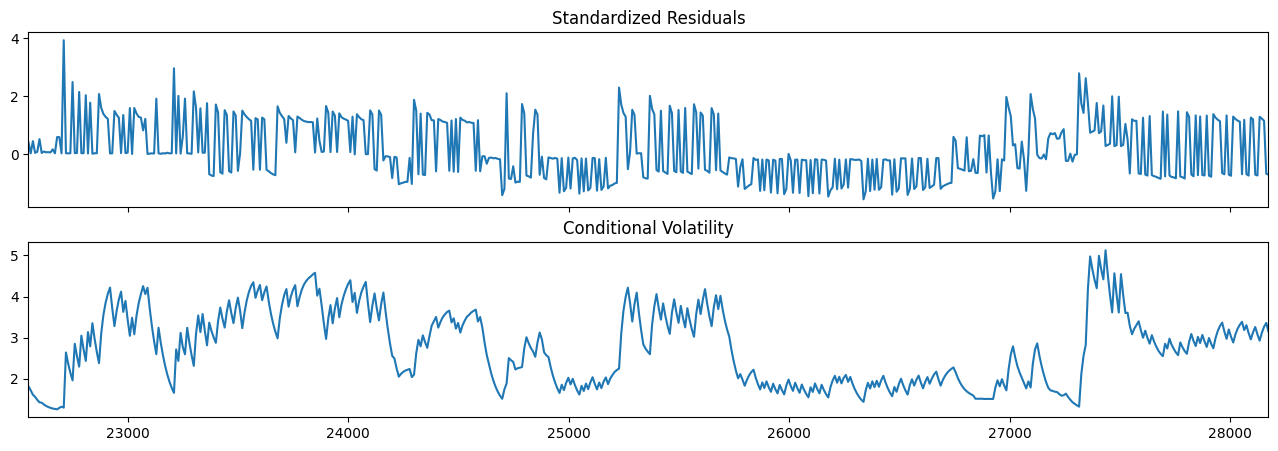

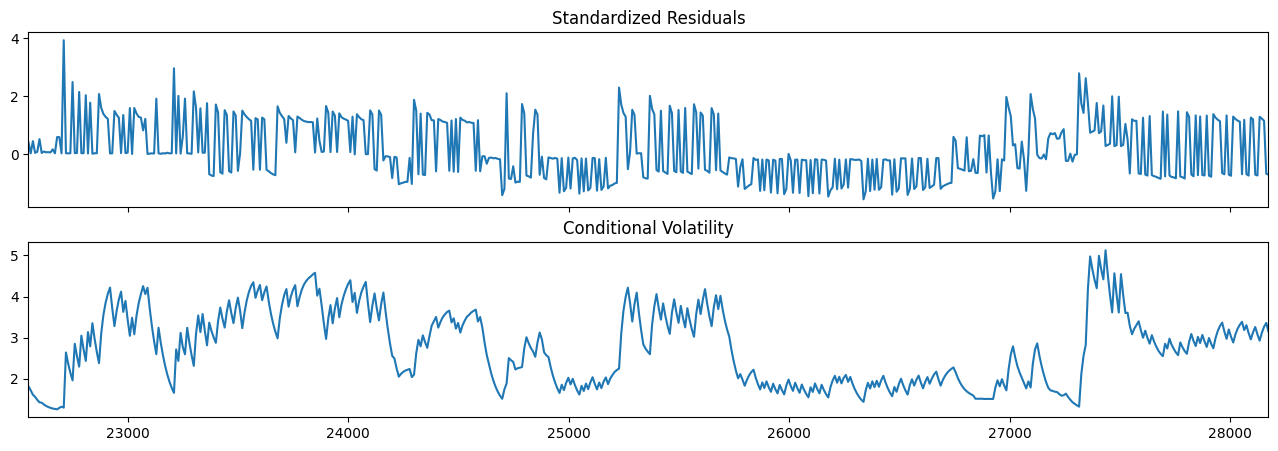

In [10]:
garch_fit.plot()